# ERA5-Land Monthly Averaged (Use case)

Variable: 2m_temperature

## Import dependencies

In [84]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import leafmap
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd
from shapely.vectorized import contains
import shapely

import os

## Manage Working Directories

In [85]:
# The directories (if doesn't exist) will be created in the Data folder
download_folder = r".\data\era5-land-monthly-means\download"
working_folder = r".\data\era5-land-monthly-means\working"
output_folder = r".\data\era5-land-monthly-means\output"

## Read the downloaded dataset

In [86]:
filename = "reanalysis-era5-land-monthly-means_2m_temperature_1950-2024.nc"
filepath = os.path.join(download_folder,filename)
dataset = nc.Dataset(filepath, mode='r')
variables_list = dataset.variables.keys()

# Read primary variable (if only 1 variable present in the netcdf file)
max_dims = 0
for var in variables_list:
    variable_obj = dataset.variables[var]
    num_dims = len(variable_obj.dimensions)
    if num_dims > max_dims:
        max_dims = num_dims
        primary_variable = var
        
primary_variable

't2m'

#### Useful other

In [87]:
lon_list = dataset['longitude']
lat_list = dataset['latitude']
variable_data = dataset[primary_variable]

## Create Basic Plot

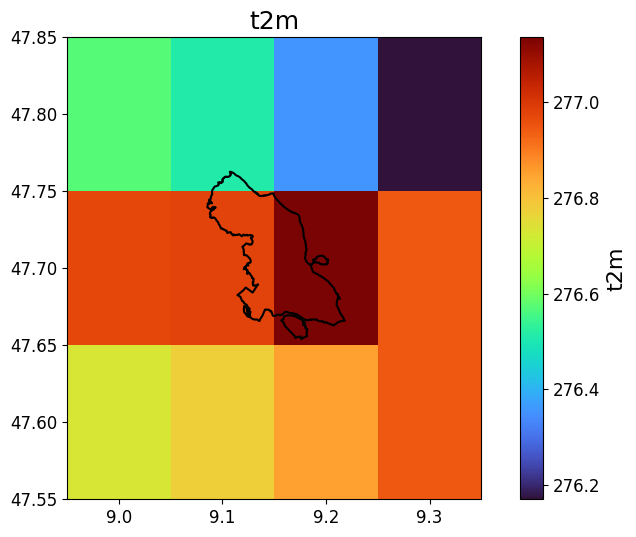

In [88]:
# Select year to plot
selected_year = 1960
year_index = selected_year - 1950

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Custom cmap
cmap = plt.get_cmap('turbo')
mesh = ax.pcolormesh(lon_list, lat_list, variable_data[year_index,:,:], cmap=cmap)

# Add a colorbar
plt.colorbar(mesh, ax=ax, label=f'{primary_variable}')

# Set title
ax.set_title(f'{primary_variable}')

# Add administrative boundary of Konstanz
germany_shp = r"F:\kn_boundary.shp"
germany_boundary = gpd.read_file(germany_shp)
germany_boundary.boundary.plot(ax=ax, edgecolor='black')

# Show the plot
plt.show()

## Interpolate to higher resolution

In [89]:
from scipy.interpolate import RegularGridInterpolator

interval = 0.005

lon_new = np.arange(np.min(lon_list), np.max(lon_list), interval)
lat_new = np.arange(np.min(lat_list), np.max(lat_list) + interval, interval)
lon_new, lat_new = np.meshgrid(lon_new, lat_new[::-1])

interpolator = RegularGridInterpolator((lat_list[:], lon_list[:]),
                                       variable_data[year_index, :, :],
                                       method='linear',
                                       bounds_error=False,
                                       fill_value=None)

# Evaluate on the new grid
interpolated_data = interpolator((lat_new, lon_new))
interpolated_data = np.round(interpolated_data, decimals=4)

In [90]:
# Administrative boundary of Germany
germany_shp = r"F:\kn_boundary.shp"
germany_boundary = gpd.read_file(germany_shp)

# Create buffer
germany_boundary_buffered = germany_boundary.copy()
germany_boundary_buffered['geometry'] = germany_boundary.geometry.buffer(interval/2, cap_style=1)

germany_polygon = germany_boundary.unary_union
mask = contains(germany_polygon, lon_new, lat_new)
masked_data = np.where(mask, interpolated_data, np.nan)

germany_polygon_buffered = germany_boundary_buffered.unary_union
mask_buffered = contains(germany_polygon_buffered, lon_new, lat_new)
masked_data_buffered = np.where(mask_buffered, interpolated_data, np.nan)

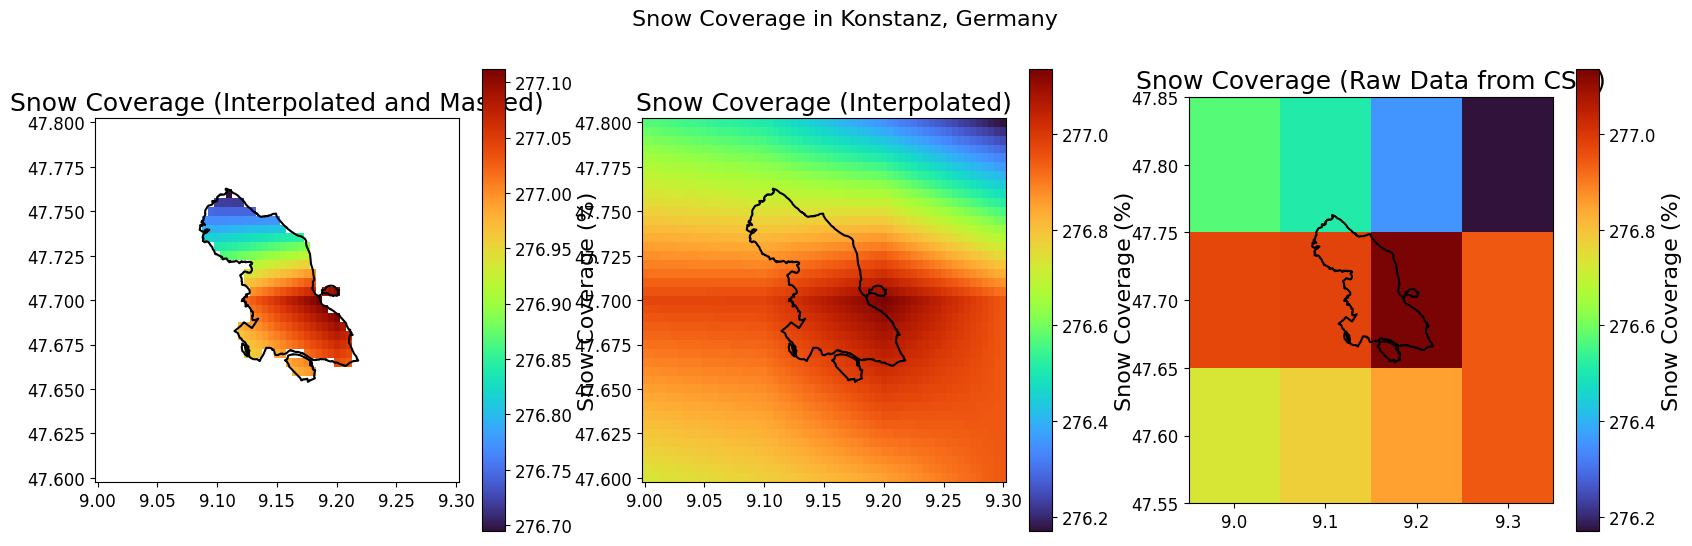

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Plot the masked data
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

ax =  axs[0]
mesh = ax.pcolormesh(lon_new, lat_new, masked_data, cmap=cmap)
# Add a colorbar
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')
# divider = make_axes_locatable(ax)  # Create a divider for the first axis
# cax = divider.append_axes("right", size="5%", pad=0.1)  # Add an axis on the right for the colorbar
# cbar = fig.colorbar(mesh, cax=cax)  # Add the colorbar to this axis
# cbar.set_label('Snow Coverage (%)')

ax.set_title('Snow Coverage (Interpolated and Masked)')
ax.set_aspect(1)
# Plot the Germany boundary on the map
germany_boundary.boundary.plot(ax=ax, edgecolor='black')

ax =  axs[1]
mesh = ax.pcolormesh(lon_new, lat_new, interpolated_data, cmap=cmap)
# Add a colorbar
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')

ax.set_title('Snow Coverage (Interpolated)')
ax.set_aspect(1)
# Plot the Germany boundary on the map
germany_boundary.boundary.plot(ax=ax, edgecolor='black')

ax =  axs[2]
mesh = ax.pcolormesh(lon_list, lat_list, variable_data[year_index, :, :], cmap=cmap)
# Add a colorbar
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')

ax.set_title('Snow Coverage (Raw Data from CSD)')
ax.set_aspect(1)
# Plot the Germany boundary on the map
germany_boundary.boundary.plot(ax=ax, edgecolor='black')

fig.suptitle('Snow Coverage in Konstanz, Germany', fontsize=16)

# Show the plot
plt.show()

In [92]:
mean_nomask_list = []
mean_masked_list = []

# for band_index in range(np.shape(variable_data)[0]):   
    
# year_list = [1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020,2023]
month_list = [(index) for index in range(np.shape(variable_data)[0])]

for month in month_list:
    band_index = month
    band_data = variable_data[band_index,:,:]
    
    interpolator = RegularGridInterpolator((lat_list[:], lon_list[:]),
                                           band_data,
                                           method='linear',
                                           bounds_error=False,
                                           fill_value=None)
    
    interpolated_data = interpolator((lat_new, lon_new))
    masked_data = np.where(mask, interpolated_data, np.nan)
    
    mean_nomask_list.append(np.nanmean(band_data))
    mean_masked_list.append(np.nanmean(masked_data))
    
import pandas as pd

df_data = {
    'month': month_list,
    'mean_nomask': mean_nomask_list,
    'mean_masked': mean_masked_list,
}

df = pd.DataFrame(df_data)
# df.head()
df

,month,mean_nomask,mean_masked
0,0,271.472412,271.694319
1,1,275.245941,275.146357
2,2,277.729828,277.720964
3,3,280.250397,280.421579
4,4,287.730133,287.968392
...,...,...,...
893,893,290.950012,291.142971
894,894,293.648254,293.848887
895,895,294.684113,294.904186
896,896,288.087860,288.293655


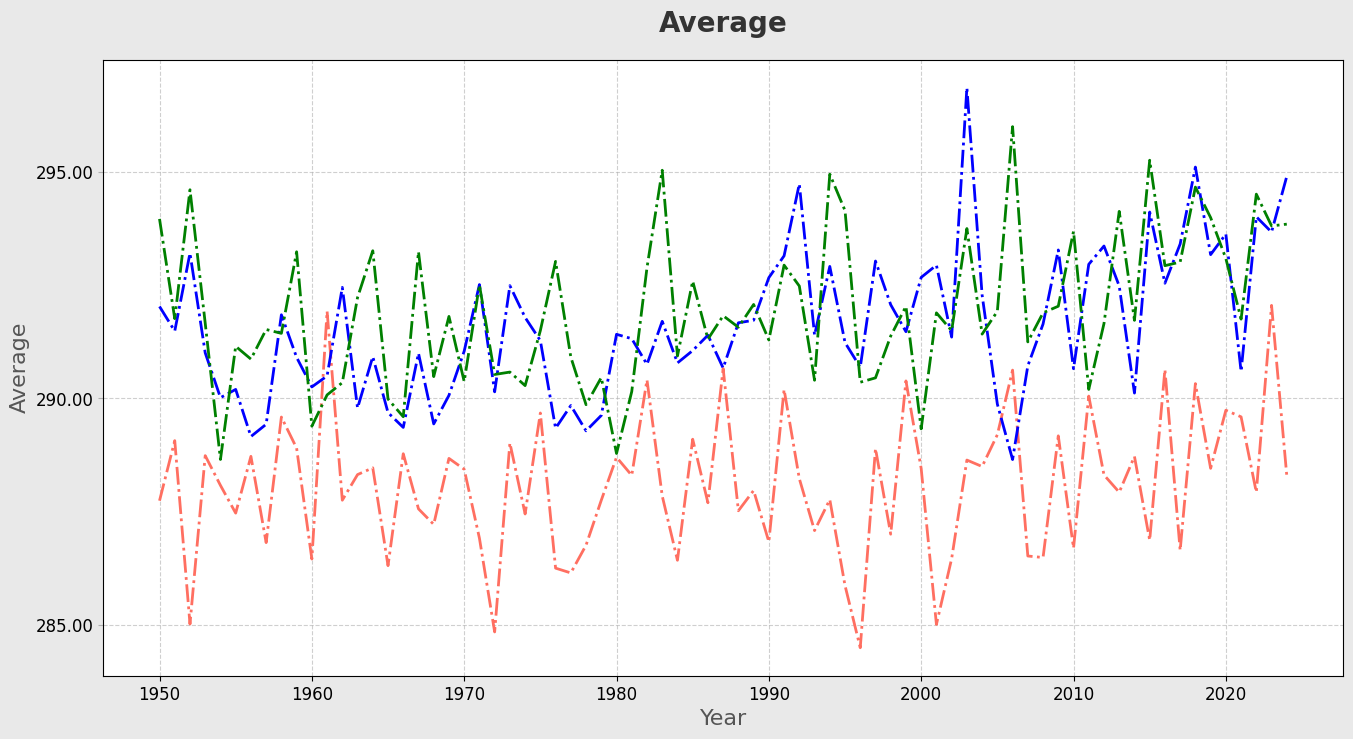

In [104]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16, 8), facecolor='#e9e9e9', edgecolor='k')

# Titles and labels
ax.set_title("Average", fontsize=20, fontweight='bold', color='#333333', pad=20)
ax.set_xlabel("Year", fontsize=16, color='#555555')
ax.set_ylabel("Average", fontsize=16, color='#555555')
params = {
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,    
}
plt.rcParams.update(params)

# Grids and ticks
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.tick_params(axis='y', which='both', color='#b0b0b0')
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.set_ylim(0,100)

def get_year_df(month_index):
    month_indices = [i for i in range(month_index, len(df), 12)]
    month_data = df.iloc[month_indices]
    years = [i // 12 + 1950 for i in month_indices]
    return month_data, years

month_data8, years8 = get_year_df(8)
month_data7, years7 = get_year_df(7)
month_data6, years6 = get_year_df(6)

line1, = ax.plot(years8,
                 month_data8['mean_masked'].astype(float),
                 label='Mean (masked, Konstanz)',
                 color='#ff6f61',
                 linestyle='-.',
                 linewidth=2.0)

line2, = ax.plot(years7, 
                 month_data7['mean_masked'].astype(float),
                 label='Mean (masked, Konstanz)',
                 color='blue',
                 linestyle='-.',
                 linewidth=2.0)

line3, = ax.plot(years6, 
                 month_data6['mean_masked'].astype(float),
                 label='Mean (masked, Konstanz)',
                 color='green',
                 linestyle='-.',
                 linewidth=2.0)